In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import GradientBoostingRegressor


In [3]:
missingValues = ["n/a", "na", " ", "__"]
data = pd.read_csv("/Users/aniketsingh/Desktop/SeniorProject/data/site_weather.csv",na_values = missingValues)

data.rename(columns = {'Unnamed: 0': 'Timestamp'}, inplace = True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

#First few rows
data.head()

,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
Timestamp,,,,,
2018-01-01 00:00:00+00:00,11.565,11.465,8.120,79.585,66.290
2018-01-01 00:30:00+00:00,11.515,11.460,8.160,80.060,36.525
2018-01-01 01:00:00+00:00,11.030,11.080,8.015,81.850,4.130
2018-01-01 01:30:00+00:00,10.750,10.785,7.975,83.150,0.120
2018-01-01 02:00:00+00:00,10.785,10.835,7.975,82.950,0.000


In [4]:
#Total missing values for each feature 
print("-------------Here are the missing values----------")
data.isnull().sum()

-------------Here are the missing values----------


air_temp_set_1                  107
air_temp_set_2                  127
dew_point_temperature_set_1d    167
relative_humidity_set_1         119
solar_radiation_set_1           122
dtype: int64

In [5]:
# -------- Removing Missing Values-----#

data = data.dropna()
print("-------------Here are the missing values----------")
data.isnull().sum()

-------------Here are the missing values----------


air_temp_set_1                  0
air_temp_set_2                  0
dew_point_temperature_set_1d    0
relative_humidity_set_1         0
solar_radiation_set_1           0
dtype: int64

In [6]:
# --------- Normalized-------#
scaler = MinMaxScaler()
data_norm = data.copy()
data_norm[:] = scaler.fit_transform(data_norm)
data_norm.head(1)

,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
Timestamp,,,,,
2018-01-01 00:00:00+00:00,0.26438,0.292965,0.741169,0.819823,0.063863


In [7]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [8]:
data_nrm5 = data_norm.rolling(5, center=True).median()
data_nc = data_norm.copy()
s = data_nc.shape
for j in range(s[1]):
    for i in range(s[0]):
        if is_outlier(data_nc.iloc[i, j], data_nrm5.iloc[i, j], 0.2):
            data_nc.iloc[i, j] = data_nrm5.iloc[i, j]

In [9]:
def ts_to_features(ts, n_features=61):
    X, y = np.zeros([len(ts) - n_features, n_features]), np.zeros([len(ts) - n_features, 1])
    for i in range(len(ts)-n_features):
        X[i, :] = ts[i:i+n_features]
        y[i] = ts[i+n_features]
    return X, y.flatten()

In [10]:
def ts_predict(X, y):
    lower_alpha = 0.1
    upper_alpha = 0.9
    predictions = np.ones([1, 4])
    for i in tqdm(range(1, X.shape[0])):
        lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=lower_alpha)
        mid_model = GradientBoostingRegressor(loss="ls")
        upper_model = GradientBoostingRegressor(loss="quantile",
                                                alpha=upper_alpha)
        lower_model.fit(X[:i,:], y[:i])
        mid_model.fit(X[:i,:], y[:i])
        upper_model.fit(X[:i,:], y[:i])
        
        pred = np.hstack([y[i], 
                          lower_model.predict(X[i:i+1, :]),
                          mid_model.predict(X[i:i+1, :]),
                          upper_model.predict(X[i:i+1, :])])
        predictions = np.vstack([predictions, pred])
    return predictions[1:, :]

# air_temp_set_1

In [11]:
h = data_nc.iloc[:, 0].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-10-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [12]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

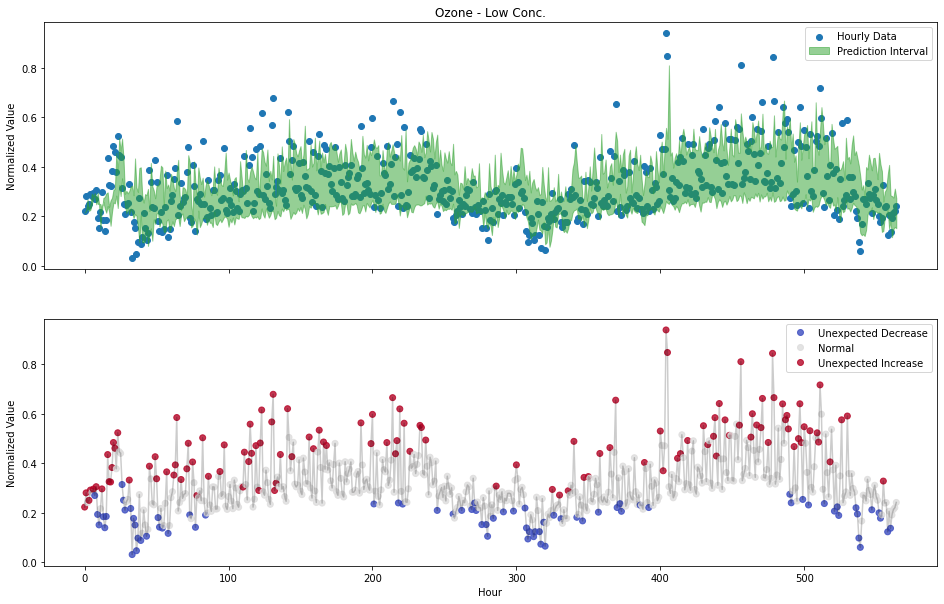

In [13]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# air_temp_set_2


In [14]:
h = data_nc.iloc[:, 1].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-10-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [15]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

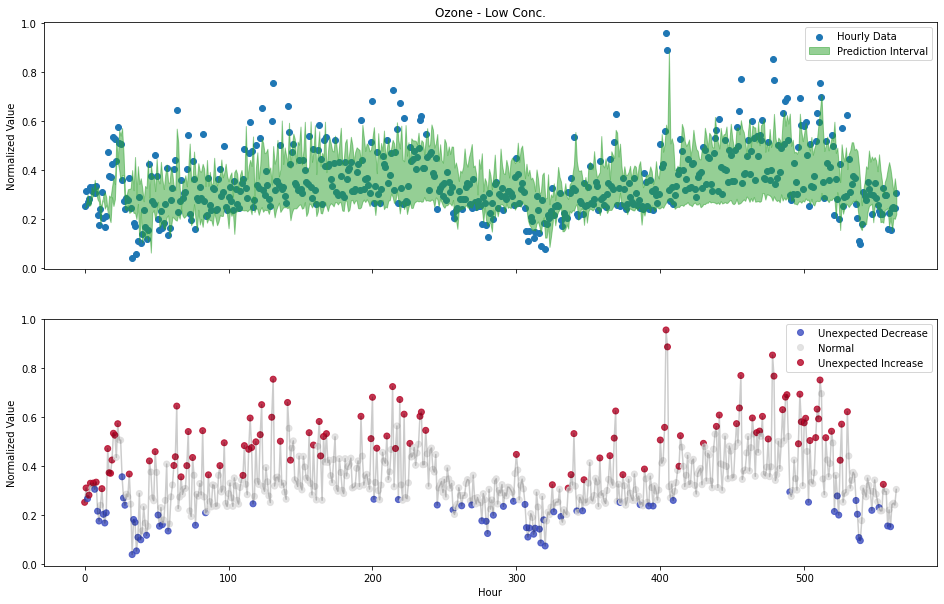

In [16]:
#Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# dew_point_temperature_set_1d

In [17]:
h = data_nc.iloc[:, 2].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-10-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [18]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

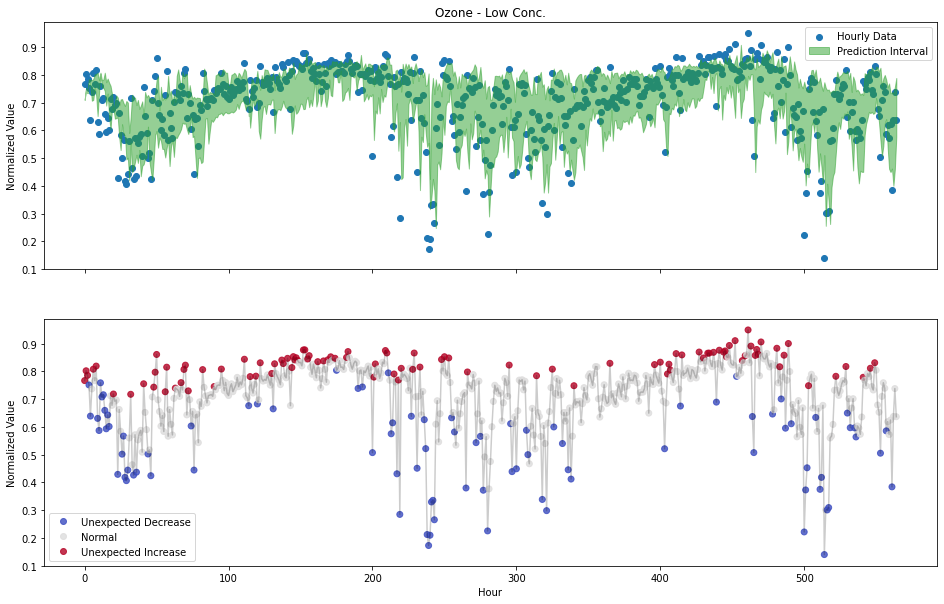

In [19]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# relative_humidity_set_1

In [20]:
h = data_nc.iloc[:, 3].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-10-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [21]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

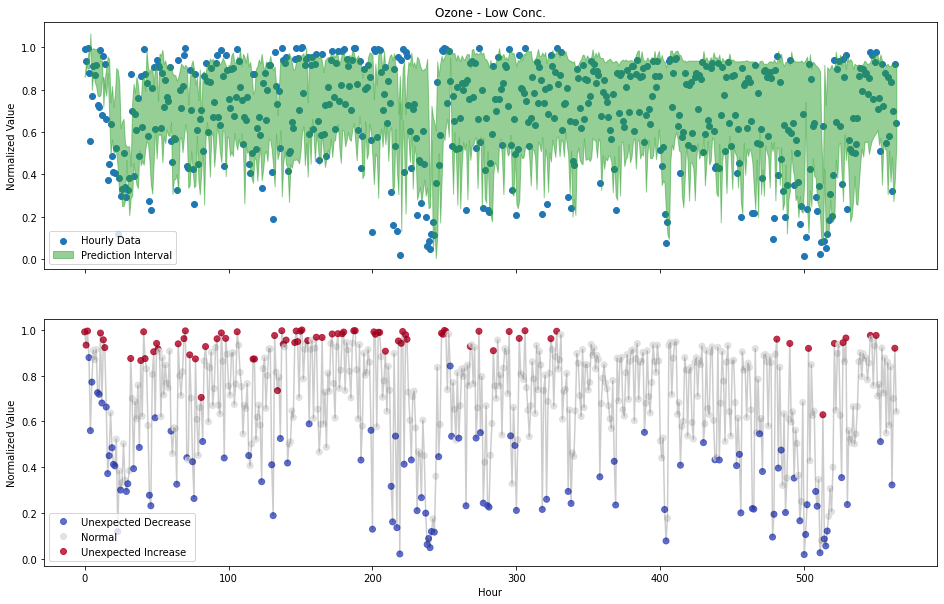

In [22]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()

# solar_radiation_set_1

In [23]:
h = data_nc.iloc[:, 4].values
h = h[range(0, len(h), 61)]
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

<ipython-input-10-bed56b3e746d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1, X.shape[0])):


In [24]:
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

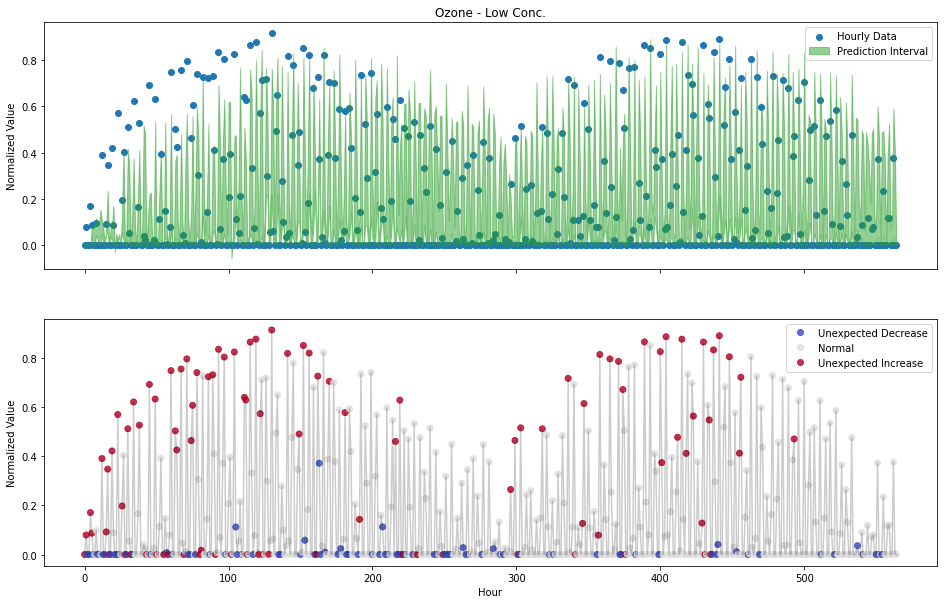

In [25]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()